# Identifying Key Predictors of Voluntary Employee Turnover - Modeling and Evaluation
*By Sophia Jensen and Duy Nguyen | July 2025*
<br> This notebooks is used for model training and evaluation.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Load in fevs_data_cleaned_final.csv

df = pd.read_csv("/Users/sophie/Downloads/ADS599_CapstoneProject/data/fevs_data_cleaned_final.csv")

# Display the first few rows of the DataFrame
df.head()

,year,dsex,dfedten,dsuper,dleaving,q1,q2,q3,q4,q5,...,q29,q30,q31,q32,q33,q34,q35,q36,q37,q38
0,2018,0.0,0.0,0.0,0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2018,0.0,0.0,0.0,1,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2,2018,0.0,0.0,0.0,0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,2018,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,2018,0.0,0.0,0.0,0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [3]:
# define the likert columns 
likert_columns = [col for col in df.columns if col.startswith('q')]

This splits the data with survey questions only

In [10]:
# Split the data into training and testing sets
# Define features and target
X = df[likert_columns]
y = df['dleaving']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# check the shape of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Balance the training set using SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

Training set shape: (2521731, 36) (2521731,)
Testing set shape: (630433, 36) (630433,)


This splits the data with survey questions and demographic columns 

In [6]:
# Split the data into training and testing sets including all demographic columns and questions 
X = df.drop(columns=['dleaving', 'year', 'dsuper'])
y = df['dleaving']  # Target variable

# Split the data
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=42)
# Balance the training set using SMOTE
smote_full = SMOTE(random_state=42)
X_train_bal_full, y_train_bal_full = smote_full.fit_resample(X_train_full, y_train_full)

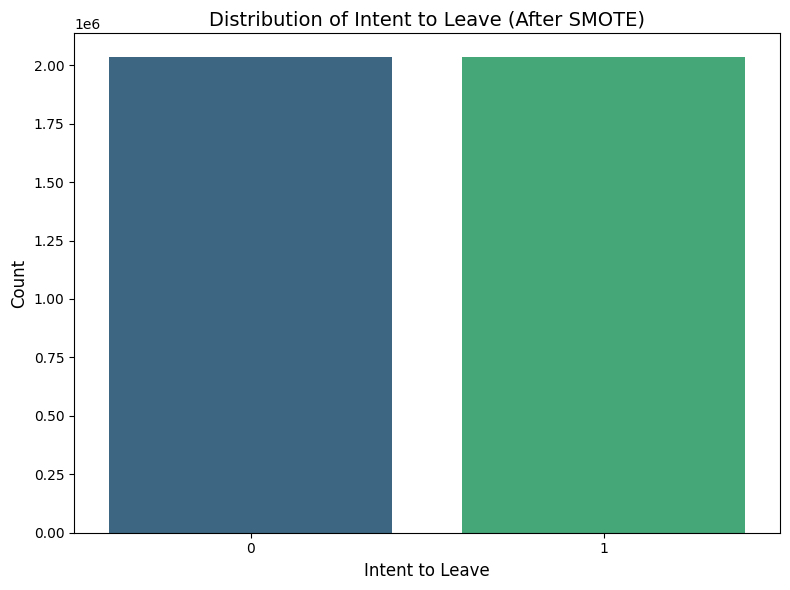

In [13]:
# Convert Series to DataFrame with column name 'dleaving'
y_train_bal_full_df = y_train_bal_full.to_frame(name='dleaving')

# Visualize the distribution of the target variable after applying SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x='dleaving', data=y_train_bal_full_df, palette='viridis')
plt.title('Distribution of Intent to Leave (After SMOTE)', fontsize=14)
plt.xlabel('Intent to Leave', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Logistic Regression


In [5]:
# Fit logistic regression on balanced training data
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_bal_full, y_train_bal_full)


# Predict on test set
y_pred = logreg.predict(X_test_full)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_full, y_pred, target_names=['Stay', 'Leave']))

# Accuracy
print("Accuracy:", accuracy_score(y_test_full, y_pred))


Classification Report:
              precision    recall  f1-score   support

        Stay       0.88      0.71      0.79    509121
       Leave       0.34      0.61      0.43    121312

    accuracy                           0.69    630433
   macro avg       0.61      0.66      0.61    630433
weighted avg       0.78      0.69      0.72    630433

Accuracy: 0.6924129923401853


In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']  # change based on penalty
}

grid_logreg = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                           param_grid, cv=5, scoring='f1')
grid_logreg.fit(X_train_bal_full, y_train_bal_full)

print("Best parameters:", grid_logreg.best_params_)

Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [7]:
best_logreg = LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)
best_logreg.fit(X_train_bal_full, y_train_bal_full)

# Evaluate
y_pred = best_logreg.predict(X_test_full)

from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test_full, y_pred, target_names=['Stay', 'Leave']))
print("Accuracy:", accuracy_score(y_test_full, y_pred))

              precision    recall  f1-score   support

        Stay       0.88      0.71      0.79    509121
       Leave       0.34      0.61      0.43    121312

    accuracy                           0.69    630433
   macro avg       0.61      0.66      0.61    630433
weighted avg       0.78      0.69      0.72    630433

Accuracy: 0.6924129923401853


In [12]:
# Build logistic regression model 
# Fit logistic regression on balanced training data
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_bal, y_train_bal)


# Predict on test set
y_pred = logreg.predict(X_test)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Stay (A/B)', 'Leave (C/D)']))

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))




Classification Report:
              precision    recall  f1-score   support

  Stay (A/B)       0.82      0.83      0.82    509121
 Leave (C/D)       0.23      0.22      0.22    121312

    accuracy                           0.71    630433
   macro avg       0.52      0.52      0.52    630433
weighted avg       0.70      0.71      0.71    630433

Accuracy: 0.7089143493440223


## Decision Tree 

In [15]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(
    max_depth=15,
    min_samples_leaf=50,
    class_weight='balanced',
    random_state=42
)

clf.fit(X_train_full, y_train_full)

# Predict on test set
y_pred = clf.predict(X_test_full)
# Classification report
print("\nDecision Tree Classification Report:")
print(classification_report(y_test_full, y_pred, target_names=['Stay', 'Leave']))

# Accuracy
print("Decision Tree Accuracy:", accuracy_score(y_test_full, y_pred))


Decision Tree Classification Report:
              precision    recall  f1-score   support

        Stay       0.89      0.69      0.78    509121
       Leave       0.33      0.62      0.43    121312

    accuracy                           0.68    630433
   macro avg       0.61      0.66      0.60    630433
weighted avg       0.78      0.68      0.71    630433

Decision Tree Accuracy: 0.6804196480831428


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [10, 50, 100],
    'min_samples_split': [10, 50],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # Use 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_full, y_train_full)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.best_estimator_.predict(X_test_full)
print("\nOptimized Decision Tree Classification Report:")
print(classification_report(y_test_full, y_pred, target_names=['Stay', 'Leave']))
print("Optimized Decision Tree Accuracy:", accuracy_score(y_test_full, y_pred))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


## XGBoost 


XGBoost Classification Report:
              precision    recall  f1-score   support

  Stay (A/B)       0.82      0.85      0.83    509121
 Leave (C/D)       0.23      0.19      0.21    121312

    accuracy                           0.72    630433
   macro avg       0.52      0.52      0.52    630433
weighted avg       0.70      0.72      0.71    630433

XGBoost Accuracy: 0.7241134268034827


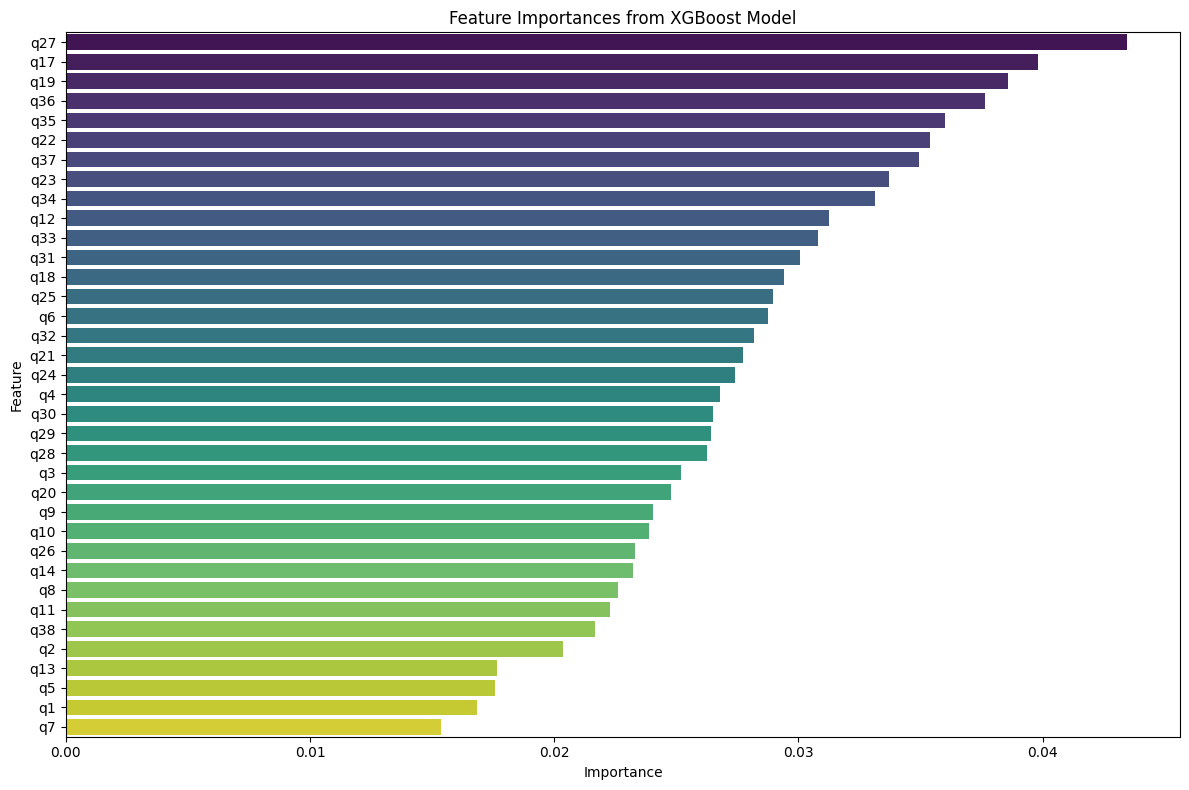

In [ ]:
# Build XGBoost model

# Fit XGBoost on balanced training data
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Classification report for XGBoost
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Stay (A/B)', 'Leave (C/D)']))

# Accuracy for XGBoost
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

# Feature importance for XGBoost
importances_xgb = xgb_model.feature_importances_

# Create a DataFrame for feature importances
feature_importances_xgb = pd.DataFrame({
    'Feature': X_train_bal.columns,
    'Importance': importances_xgb
}).sort_values(by='Importance', ascending=False)

# Plot feature importances for XGBoost
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_xgb, palette='viridis')
plt.title('Feature Importances from XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()



XGBoost Classification Report:
              precision    recall  f1-score   support

        Stay       0.83      0.96      0.89    509121
       Leave       0.50      0.16      0.24    121312

    accuracy                           0.81    630433
   macro avg       0.66      0.56      0.57    630433
weighted avg       0.77      0.81      0.77    630433

XGBoost Accuracy: 0.8077813185540732


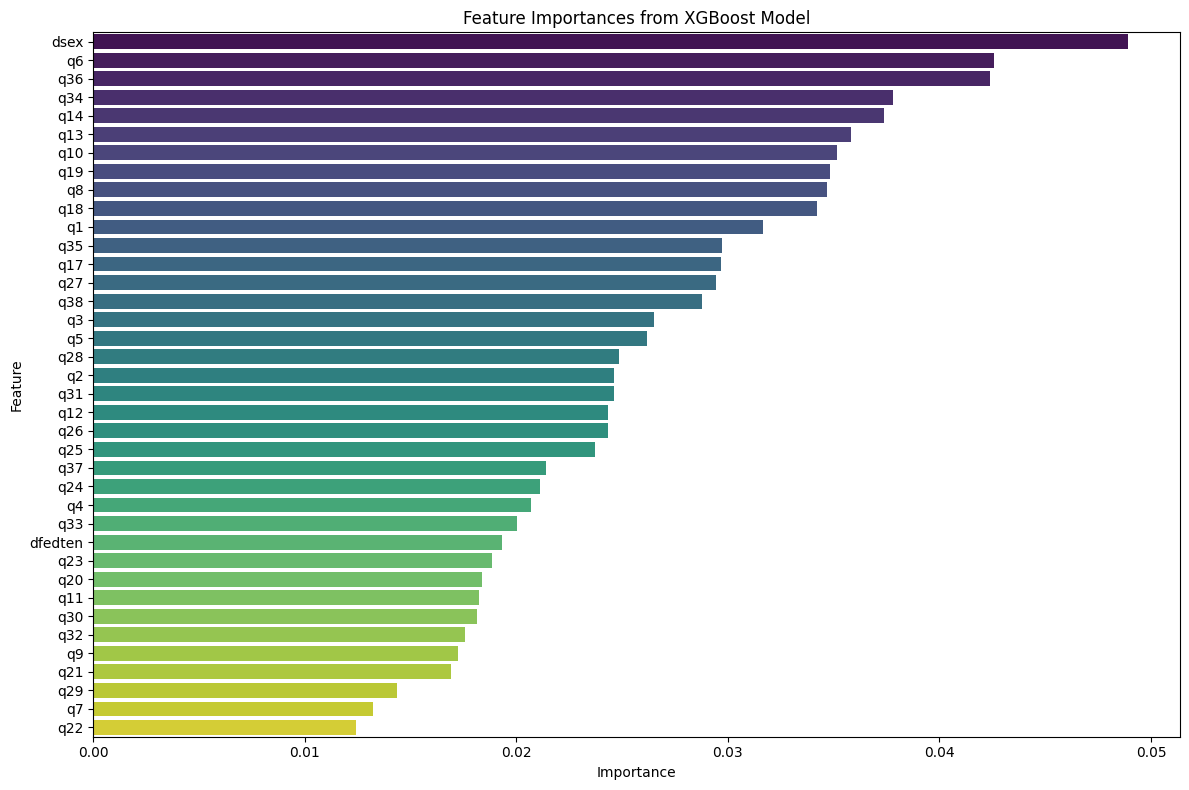

In [19]:
# Build XGBoost model

# Fit XGBoost on balanced training data
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_bal_full, y_train_bal_full)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test_full)

# Classification report for XGBoost
print("\nXGBoost Classification Report:")
print(classification_report(y_test_full, y_pred_xgb, target_names=['Stay', 'Leave']))

# Accuracy for XGBoost
print("XGBoost Accuracy:", accuracy_score(y_test_full, y_pred_xgb))

# Feature importance for XGBoost
importances_xgb = xgb_model.feature_importances_

# Create a DataFrame for feature importances
feature_importances_xgb = pd.DataFrame({
    'Feature': X_train_bal_full.columns,
    'Importance': importances_xgb
}).sort_values(by='Importance', ascending=False)

# Plot feature importances for XGBoost
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_xgb, palette='viridis')
plt.title('Feature Importances from XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
